<a href="https://colab.research.google.com/github/nikitashchigolev/Anti-Fraud-transactions/blob/main/Anti_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Импорт необходимых библиотек

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Экспорт данных

In [ ]:
labeled_transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Финбез/hits0712.csv', index_col=0)
transaction_history = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Финбез/hist_trx.csv', index_col=0)

In [ ]:
labeled_transactions.head(10000000)

,event_id,user_id,rec_user_id,date_time,resolution,sub_channel
5,0fcea7fec4ff479cac8cf37b4555c817,75301207,49913000,2018-12-07 07:56:49,G,ATMAPI
6,c29a4e64d27b435b9b55aa3e62ce54d4,1200695,12797310,2018-12-07 07:14:41,G,MOBILEAPI
8,3107b2b1afcb490ab0a31135eb4b386c,45657780,23814017,2018-12-07 14:02:30,G,MOBILEAPI
10,d9bc95d991144d53b950d8084fa846bf,21683486,9865131,2018-12-07 10:32:41,G,WEBAPI
22,9fc959da4cd144ea8bf5bae2dc041a5e,4531894,VSP15472255,2018-12-07 18:22:52,G,MOBILEAPI
...,...,...,...,...,...,...
23682,28ea1a08c79240449922d5756646a353,92237374,69162645,2018-12-07 17:46:35,G,MOBILEAPI
23683,65a5b1dd74564e99b3b3c39b9ee460f7,3316389,89796796,2018-12-07 18:42:47,G,WEBAPI
23684,df808870913643c7ba24e990e6bbea39,24338601,58490342,2018-12-07 13:55:59,G,MOBILEAPI
23685,de1b30f52c264e95816e0cc163b2c116,2000352,37033043,2018-12-07 17:55:32,G,ATMAPI


In [ ]:
transaction_history.head(10000000)

,event_id,date_time,user_id,sub_channel,event_type,sub_type,atm_mcc,mcc_group,atm_merchant_name,amount
0,22c9f1ac686a43e18cdb798489193238,2018-12-06 09:33:21,102050167,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5921.0,R,YUG 426,280.00
1,62dac13fac68416d9bc340c51ddcb977,2018-12-06 09:36:08,102050167,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5331.0,R,MAGAZIN RODINA,376.90
2,9b666b8c9d4d4faea78e2b28a5468794,2018-12-06 12:21:02,102050167,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5921.0,R,YUG 426,143.00
3,d4d805fc3d5f4c91aa9b0389333b780c,2018-12-06 07:46:58,102050167,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5331.0,R,MAGAZIN RODINA,162.00
4,1d162351117a4418949dcf94111b9964,2018-12-06 12:21:27,102050167,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5331.0,R,MAGAZIN RODINA,56.00
...,...,...,...,...,...,...,...,...,...,...
53558,cdab8f7285a146a0959a079fe0628d75,2018-11-27 18:14:11,VSP14440557,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5411.0,R,PYATEROCHKA 9500,273.57
53559,20be17c6aaf2443dacb8e23cc0ba1652,2018-11-27 19:18:13,VSP14440557,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,4829.0,U,SBOL,7500.00
53560,d99981bfd29c42b39209775d04564f4f,2018-11-27 19:17:27,VSP14440557,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,4829.0,U,SBOL,2000.00
53561,304543b0e67d4251b2811e10890ef60c,2018-11-27 07:20:05,VSP14440557,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5999.0,R,KREPOST,110.00


# Получение экспертной оценки части пользователей для последующего мёржа

In [ ]:
labels = pd.DataFrame({
  'user_id': labeled_transactions.rec_user_id,
  'is_fraud': labeled_transactions.resolution.map(lambda x: {'G': 0, 'F': 1, 'S': 1}[x]
)
}).drop_duplicates('user_id')
history = transaction_history[['event_id', 'user_id', 'event_type', 'atm_mcc', 'amount', 'date_time']].dropna().reset_index(drop=True)
history_full = transaction_history[['event_id', 'user_id', 'event_type', 'atm_mcc', 'amount', 'date_time']].dropna().reset_index(drop=True)
labels.head(100000)

,user_id,is_fraud
5,49913000,0
6,12797310,0
8,23814017,0
10,9865131,0
22,VSP15472255,0
...,...,...
23682,69162645,0
23683,89796796,0
23684,58490342,0
23685,37033043,0


# Добавление нового признака - час совершения транзакции

In [ ]:
history['date_time'] = history['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
history['hour'] = history['date_time'].apply(lambda x: x.hour)
history.drop('date_time', axis=1, inplace=True)

history.head(1000000)

,event_id,user_id,event_type,atm_mcc,amount,hour
0,22c9f1ac686a43e18cdb798489193238,102050167,PAYMENT,5921.0,280.00,9
1,62dac13fac68416d9bc340c51ddcb977,102050167,PAYMENT,5331.0,376.90,9
2,9b666b8c9d4d4faea78e2b28a5468794,102050167,PAYMENT,5921.0,143.00,12
3,d4d805fc3d5f4c91aa9b0389333b780c,102050167,PAYMENT,5331.0,162.00,7
4,1d162351117a4418949dcf94111b9964,102050167,PAYMENT,5331.0,56.00,12
...,...,...,...,...,...,...
561349,cdab8f7285a146a0959a079fe0628d75,VSP14440557,PAYMENT,5411.0,273.57,18
561350,20be17c6aaf2443dacb8e23cc0ba1652,VSP14440557,PAYMENT,4829.0,7500.00,19
561351,d99981bfd29c42b39209775d04564f4f,VSP14440557,PAYMENT,4829.0,2000.00,19
561352,304543b0e67d4251b2811e10890ef60c,VSP14440557,PAYMENT,5999.0,110.00,7


# One Hot Encoding

In [ ]:
userids_train = history['user_id'].copy()
eventids_train = history['event_id'].copy()

history.drop('user_id', axis=1, inplace=True)
history.drop('event_id', axis=1, inplace=True)
history = pd.get_dummies(history)
history_full = history.copy()

# Стандартизация

In [ ]:
# создание объекта scaler
scaler = StandardScaler()
# выбор некатегориальных признаков для стандартизации
numeric_features = ['atm_mcc', 'amount', 'hour']
# стандартизация признаков
history[numeric_features] = scaler.fit_transform(history[numeric_features])

history.insert(0, 'event_id', eventids_train)
history.insert(0, 'user_id', userids_train)
history_full = history.copy()
history = history.merge(labels, on='user_id')

history.head(1000000)

,user_id,event_id,atm_mcc,amount,hour,event_type_CARD_PIN_CHANGE,event_type_CLIENT_DEFINED,event_type_DEPOSIT,event_type_PAYMENT,event_type_UPDATE_USER,event_type_VIEW_STATEMENT,event_type_WITHDRAW,is_fraud
0,102050167,22c9f1ac686a43e18cdb798489193238,0.444772,-0.153425,-0.583393,0,0,0,1,0,0,0,0
1,102050167,62dac13fac68416d9bc340c51ddcb977,-0.378249,-0.152097,-0.583393,0,0,0,1,0,0,0,0
2,102050167,9b666b8c9d4d4faea78e2b28a5468794,0.444772,-0.155301,0.030651,0,0,0,1,0,0,0,0
3,102050167,d4d805fc3d5f4c91aa9b0389333b780c,-0.378249,-0.155041,-0.992756,0,0,0,1,0,0,0,0
4,102050167,1d162351117a4418949dcf94111b9964,-0.378249,-0.156493,0.030651,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268077,101133668,9e32e8a958d14465b26b7258793ca235,-1.078515,-0.109316,-0.174031,0,0,0,1,0,0,0,0
268078,101133668,d793e9f0c6d94f1a93ad63886f2e3385,0.570318,-0.157247,-0.174031,0,0,1,0,0,0,0,0
268079,52894743,fc4012d589d14011acc2fdbce7e16967,-0.266653,-0.153400,-0.788074,0,0,0,1,0,0,0,0
268080,96646715,b6c855d89b2b4b7f8acdde2d7ecda49f,-1.078515,-0.062741,-0.992756,0,0,0,1,0,0,0,0


In [ ]:
history_full.head(1000000)

,user_id,event_id,atm_mcc,amount,hour,event_type_CARD_PIN_CHANGE,event_type_CLIENT_DEFINED,event_type_DEPOSIT,event_type_PAYMENT,event_type_UPDATE_USER,event_type_VIEW_STATEMENT,event_type_WITHDRAW
0,102050167,22c9f1ac686a43e18cdb798489193238,0.444772,-0.153425,-0.583393,0,0,0,1,0,0,0
1,102050167,62dac13fac68416d9bc340c51ddcb977,-0.378249,-0.152097,-0.583393,0,0,0,1,0,0,0
2,102050167,9b666b8c9d4d4faea78e2b28a5468794,0.444772,-0.155301,0.030651,0,0,0,1,0,0,0
3,102050167,d4d805fc3d5f4c91aa9b0389333b780c,-0.378249,-0.155041,-0.992756,0,0,0,1,0,0,0
4,102050167,1d162351117a4418949dcf94111b9964,-0.378249,-0.156493,0.030651,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
561349,VSP14440557,cdab8f7285a146a0959a079fe0628d75,-0.266653,-0.153513,1.258739,0,0,0,1,0,0,0
561350,VSP14440557,20be17c6aaf2443dacb8e23cc0ba1652,-1.078515,-0.054522,1.463420,0,0,0,1,0,0,0
561351,VSP14440557,d99981bfd29c42b39209775d04564f4f,-1.078515,-0.129863,1.463420,0,0,0,1,0,0,0
561352,VSP14440557,304543b0e67d4251b2811e10890ef60c,0.553578,-0.155753,-0.992756,0,0,0,1,0,0,0


# Матрица корреляции полученных признаков

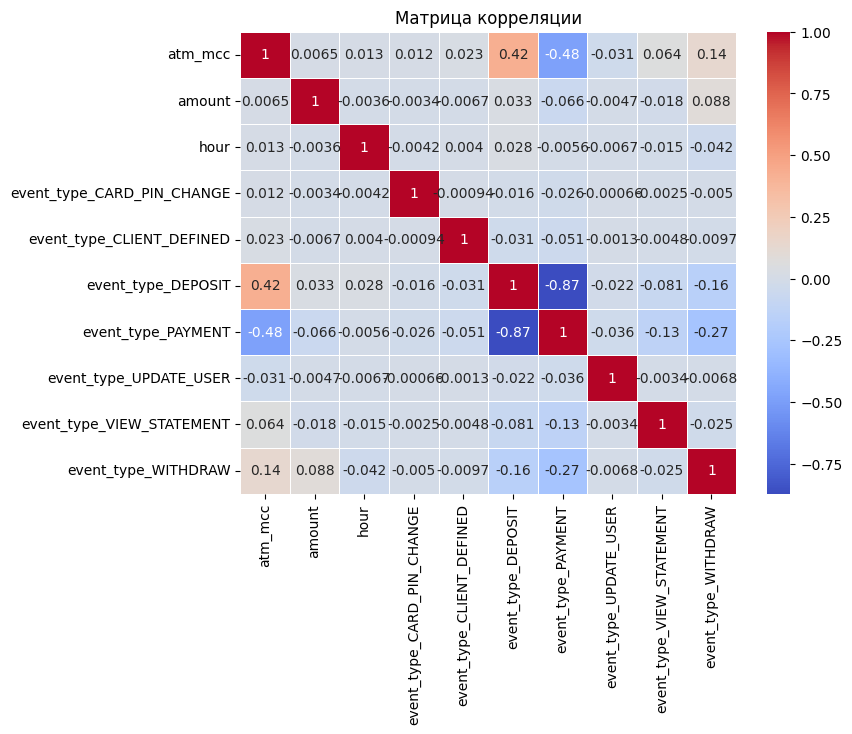

In [ ]:
correlation_matrix = history_full.corr()

# Создание тепловой карты корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Матрица корреляции")
plt.show()

In [ ]:
history_full = history_full[~history_full['user_id'].isin(history['user_id'])]
history_full.head(1000000)

,user_id,event_id,atm_mcc,amount,hour,event_type_CARD_PIN_CHANGE,event_type_CLIENT_DEFINED,event_type_DEPOSIT,event_type_PAYMENT,event_type_UPDATE_USER,event_type_VIEW_STATEMENT,event_type_WITHDRAW
5,103002198,aefeb02b129c44a291340f25a54ed975,-1.078515,-0.131507,-0.174031,0,0,0,1,0,0,0
6,103002198,17bff3e94d3745c088310869f8ef9467,0.570318,-0.155890,-0.174031,0,0,0,0,0,0,1
7,103002198,afea97cc889b48a399c3f67dda7fce41,0.570318,-0.129863,0.849376,0,0,1,0,0,0,0
8,103002198,c6b075939a984539811a2bb1043c5ee4,-1.078515,-0.130137,0.849376,0,0,0,1,0,0,0
9,103002198,3a338f1ee3ad453e8b7eb02aa5a9b239,0.570318,-0.157247,0.849376,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
561331,MBK7466633,b822012888fa4cfd8639e995276d31bf,0.570318,0.013970,-0.788074,0,0,0,0,0,0,1
561332,MBK7466633,fdc5add5a35847518db429d32cc125b1,-1.078515,-0.113425,-0.992756,0,0,0,1,0,0,0
561333,MBK7466633,987d28fa18fc438b90f8439809db0c06,0.568923,-0.134658,-0.992756,0,0,1,0,0,0,0
561334,MBK7466633,ffda919397754175b02280a8d7c1f988,0.570318,-0.157260,-0.788074,0,0,0,0,0,1,0


In [ ]:
userids_test = history_full['user_id'].copy()
eventids_test = history_full['event_id'].copy()

# Даунсэмплинг датасета для предотвращения дисбаланса классов

In [ ]:
# разделение датасета на классы
class_0 = history[history['is_fraud'] == 0]
class_1 = history[history['is_fraud'] == 1]

# downsampling класса 0 до размера класса 1
class_0_downsampled = resample(class_0,
                               replace=False,  # без повторений
                               n_samples=len(class_1),  # размер класса 1
                               random_state=42)  # для воспроизводимости

# объединение классов
history_downsampled = pd.concat([class_0_downsampled, class_1])

In [ ]:
X, y = history_downsampled.drop(['is_fraud'], axis=1), history_downsampled['is_fraud']
print(X.shape)
print(y.shape)
value_counts = history_downsampled['is_fraud'].value_counts()
print("Уникальные значения в столбце 'Column1' и их количество:")
print(value_counts)

(4118, 12)
(4118,)
Уникальные значения в столбце 'Column1' и их количество:
0    2059
1    2059
Name: is_fraud, dtype: int64


In [ ]:
userids_train = X['user_id'].copy()
eventids_train = X['event_id'].copy()
X.drop('user_id', axis=1, inplace=True)
X.drop('event_id', axis=1, inplace=True)
history_full.drop('user_id', axis=1, inplace=True)
history_full.drop('event_id', axis=1, inplace=True)

# Обучение моделей Logistic Regression, Random Forest и SVM с подбором гиперпараметров GridSearchCV и кросс-валидацией. Оценка качества моделей: матрица ошибок и F1-score/ROC-AUC

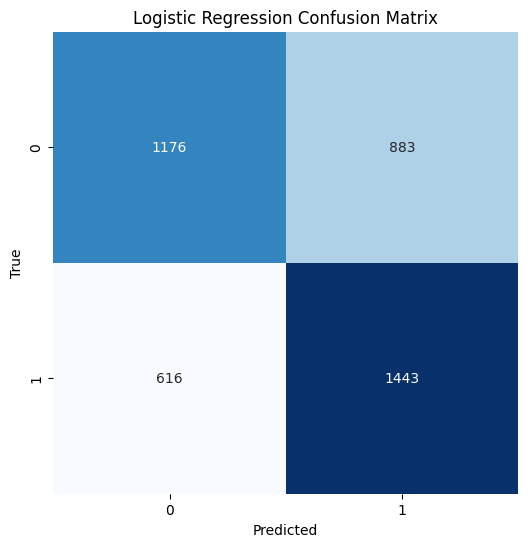

Модель: Logistic Regression
Лучшие гиперпараметры: {'C': 0.01}
F1-счет: 0.6581527936145951
ROC AUC: 0.7075958118458369



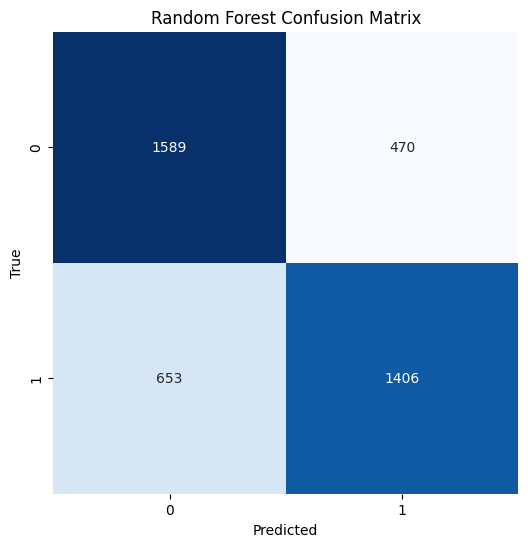

Модель: Random Forest
Лучшие гиперпараметры: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
F1-счет: 0.7146124523506988
ROC AUC: 0.9488135458090271



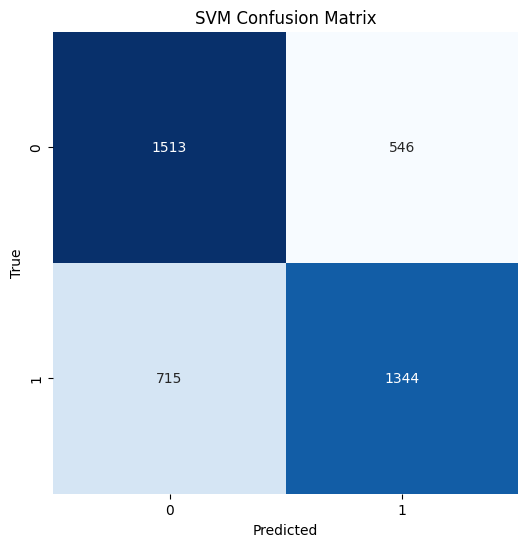

Модель: SVM
Лучшие гиперпараметры: {'C': 10, 'kernel': 'rbf'}
F1-счет: 0.6806786528234997
ROC AUC: 0.7538211634867569



In [ ]:
# Определение сетки гиперпараметров для каждой модели
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC(probability=True))  # SVM требует параметр probability=True для ROC AUC
]

# Создание объекта KFold для k-fold кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models:
    if model_name == 'Logistic Regression':
        grid_search = GridSearchCV(model, param_grid_lr, cv=kf, scoring='f1')
    elif model_name == 'Random Forest':
        grid_search = GridSearchCV(model, param_grid_rf, cv=kf, scoring='f1')
    elif model_name == 'SVM':
        grid_search = GridSearchCV(model, param_grid_svc, cv=kf, scoring='f1')

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_

    y_pred = cross_val_predict(best_model, X, y, cv=kf)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, best_model.predict_proba(X)[:, 1])  # для ROC AUC используем вероятности

    # Вывод матрицы ошибок в виде рисунка
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Вывод метрик качества модели
    print(f"Модель: {model_name}")
    print("Лучшие гиперпараметры:", grid_search.best_params_)
    print("F1-счет:", f1)
    print("ROC AUC:", roc_auc)
    print()
    joblib.dump(best_model, f"best_model_{model_name}.joblib")

In [ ]:
X.insert(0, 'event_id', eventids_train)
X.insert(0, 'user_id', userids_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

userids_train = X_test['user_id'].copy()
eventids_train = X_test['event_id'].copy()

X_test.drop('user_id', axis=1, inplace=True)
X_test.drop('event_id', axis=1, inplace=True)

# Получение лучшей модели и предсказаний по тестовой выборке и новым данным

In [ ]:
loaded_model = joblib.load("best_model_Random Forest.joblib")

predictions_TP = loaded_model.predict(X_test)
X_test['Predicted_Labels'] = predictions_TP

predictions_new_data = loaded_model.predict(history_full)  # history_full - новые данные, для которых целесообразно сделать предсказания
history_full['Predicted_Labels'] = predictions_new_data

In [ ]:
X_test.insert(0, 'event_id', eventids_train)
X_test.insert(0, 'user_id', userids_train)

# Построчный вывод мошеннических транзакций (TP) с информацией об user_id и event_id

In [ ]:
X_test[['user_id', 'event_id', 'Predicted_Labels']].head(100000)

,user_id,event_id,Predicted_Labels
65181,72300748,c947a8d0a0a64f7abc0dbef19203d85f,1
100421,40692980,9210e01b87d44611975bbfcbd68c8e1e,0
18598,101272872,9b72ffa005764703a82984b033e42317,1
25954,51609639,7cbef2faba764d56a6078142901cceb1,0
203632,86826848,cadd71f010104a66b0dfb8049fce8a34,1
...,...,...,...
233231,26024565,c053c66fca674e9f929b4ff51cecbdeb,1
223410,106439794,1c84b477ae8c4ce39eedeefa34e63662,1
185424,34696112,15b12bd58b3c486786e6f3c4b23e02ff,0
154797,51080203,dc560a19ce3e42b29bed3ae0ed84876a,1


In [ ]:
history_full.insert(0, 'event_id', eventids_test)
history_full.insert(0, 'user_id', userids_test)

# Дополнительно. Построчный вывод мошеннических транзакций из новых данных

In [ ]:
history_full[['user_id', 'event_id', 'Predicted_Labels']].head(1000000)

,user_id,event_id,Predicted_Labels
5,103002198,aefeb02b129c44a291340f25a54ed975,0
6,103002198,17bff3e94d3745c088310869f8ef9467,0
7,103002198,afea97cc889b48a399c3f67dda7fce41,0
8,103002198,c6b075939a984539811a2bb1043c5ee4,0
9,103002198,3a338f1ee3ad453e8b7eb02aa5a9b239,0
...,...,...,...
561331,MBK7466633,b822012888fa4cfd8639e995276d31bf,1
561332,MBK7466633,fdc5add5a35847518db429d32cc125b1,0
561333,MBK7466633,987d28fa18fc438b90f8439809db0c06,0
561334,MBK7466633,ffda919397754175b02280a8d7c1f988,1


# Дополнительно. Вывод потенциальных дропов по их user_id

In [ ]:
# Фильтрация строки, где Predicted_labels равен 1
filtered_df = history_full[history_full['Predicted_Labels'] == 1]

# Получение уникальных значений user_id из отфильтрованного датафрейма
drops = filtered_df['user_id'].unique()

# Вывод потенциальных дропов уникальных user_id
print(drops)

['11046246' '12660274' '13062864' ... '101324366' '71828077' 'MBK6330627']
